In [14]:
import torch
import pyheif
import faiss
import pickle
import glob
import string
import cv2
import tempfile
import pytesseract
import numpy as np
import pandas as pd
from PIL import Image
from typing import Tuple
from torchvision import models, transforms, datasets
import matplotlib.pyplot as plt
from _collections import defaultdict

In [2]:
PATH_TO_FILES = 'products'
PATH_TO_FAISS_INDEX = 'output/faiss.index'
PATH_TO_PRODUCT_DATASET = 'output/product_keywords.pkl'
PATH_TO_CBIR_MODEL = 'output/cbir.pkl'

# 1. Создание CBIR модели

Модификация класса ImageFolder для извлечения названия файла

In [3]:
class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    Source: https://gist.github.com/andrewjong/6b02ff237533b3b2c554701fb53d5c4d
    """
    
    # override the __getitem__ method. this is the method that dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

Вспомогательные функции для чтения изображений

In [4]:
def is_image_file(filename: str) -> bool:
    """Checks if a file is an allowed image extension.
    Args:
        filename (string): path to a file
    Returns:
        bool: True if the filename ends with a known image extension
    """
    return has_file_allowed_extension(filename, IMG_EXTENSIONS)

def has_file_allowed_extension(filename: str, extensions: Tuple[str, ...]) -> bool:
    """Checks if a file is an allowed extension.
    Args:
        filename (string): path to a file
        extensions (tuple of strings): extensions to consider (lowercase)
    Returns:
        bool: True if the filename ends with one of given extensions
    """
    return filename.lower().endswith(extensions)

IMG_EXTENSIONS = ('.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif', '.tiff', '.webp', '.heic')

def read_heic_img(path):
    heif_file = pyheif.read(path)
    image = Image.frombytes(
        heif_file.mode, 
        heif_file.size, 
        heif_file.data,
        "raw",
        heif_file.mode,
        heif_file.stride,
        )
    return image

def heic_loader(path):
# open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        if path.endswith('.heic'):      
            img = read_heic_img(f)
        else:
            img = Image.open(f)
        return img.convert('RGB')

In [5]:
transforms_ = transforms.Compose([
    transforms.Resize(size=[224, 224], interpolation=2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])
dataset = ImageFolderWithPaths('products', transforms_, is_valid_file=is_image_file, loader=heic_loader) # our custom dataset
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1)

Установка предобученной модели

In [6]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
model = models.resnet101(pretrained=True)

Будем использовать выход последнего pooling слоя для создания дескрипторов изображения

In [7]:
def pooling_output(x):
    global model
    for layer_name, layer in model._modules.items():
        x = layer(x)
        if layer_name == 'avgpool':
            break
    return x

Извлекаем дескрипторы

In [8]:
image_paths = []
descriptors = []
model.to(DEVICE)
with torch.no_grad():
    model.eval()
    for inputs, labels, paths in dataloader:
        result = pooling_output(inputs.to(DEVICE))
        descriptors.append(result.cpu().view(1, -1).numpy())
        image_paths.append(paths)
        torch.cuda.empty_cache()

Создаем Flat индекс и добавляем векторы дескрипторов:

In [9]:
index = faiss.IndexFlatL2(2048)
descriptors = np.vstack(descriptors)
index.add(descriptors)

Функция для поиска похожих изображений. Трансформируем изображение, получаем его дескриптор и ищем 9 похожих

In [10]:
def search_img(img):
    """
    Поиск похожих изображений
    :param img: изображение для поиска похожих
    :return: (distance, indices) для 9 элементов; остортированы по уменьшению расстрояния
    distance - расстояние от вектора данного изображения до похожих
    indices - индексы похожих изображений
    """
    #index = faiss.read_index(PATH_TO_FAISS_INDEX)
    input_tensor = transforms_(img)
    input_tensor = input_tensor.view(1, *input_tensor.shape)
    with torch.no_grad():
        query_descriptors = pooling_output(input_tensor.to(DEVICE)).cpu().numpy()
        distance, indices = index.search(query_descriptors.reshape(1, 2048), 9)
    return distance, indices

## 1.2 Пример

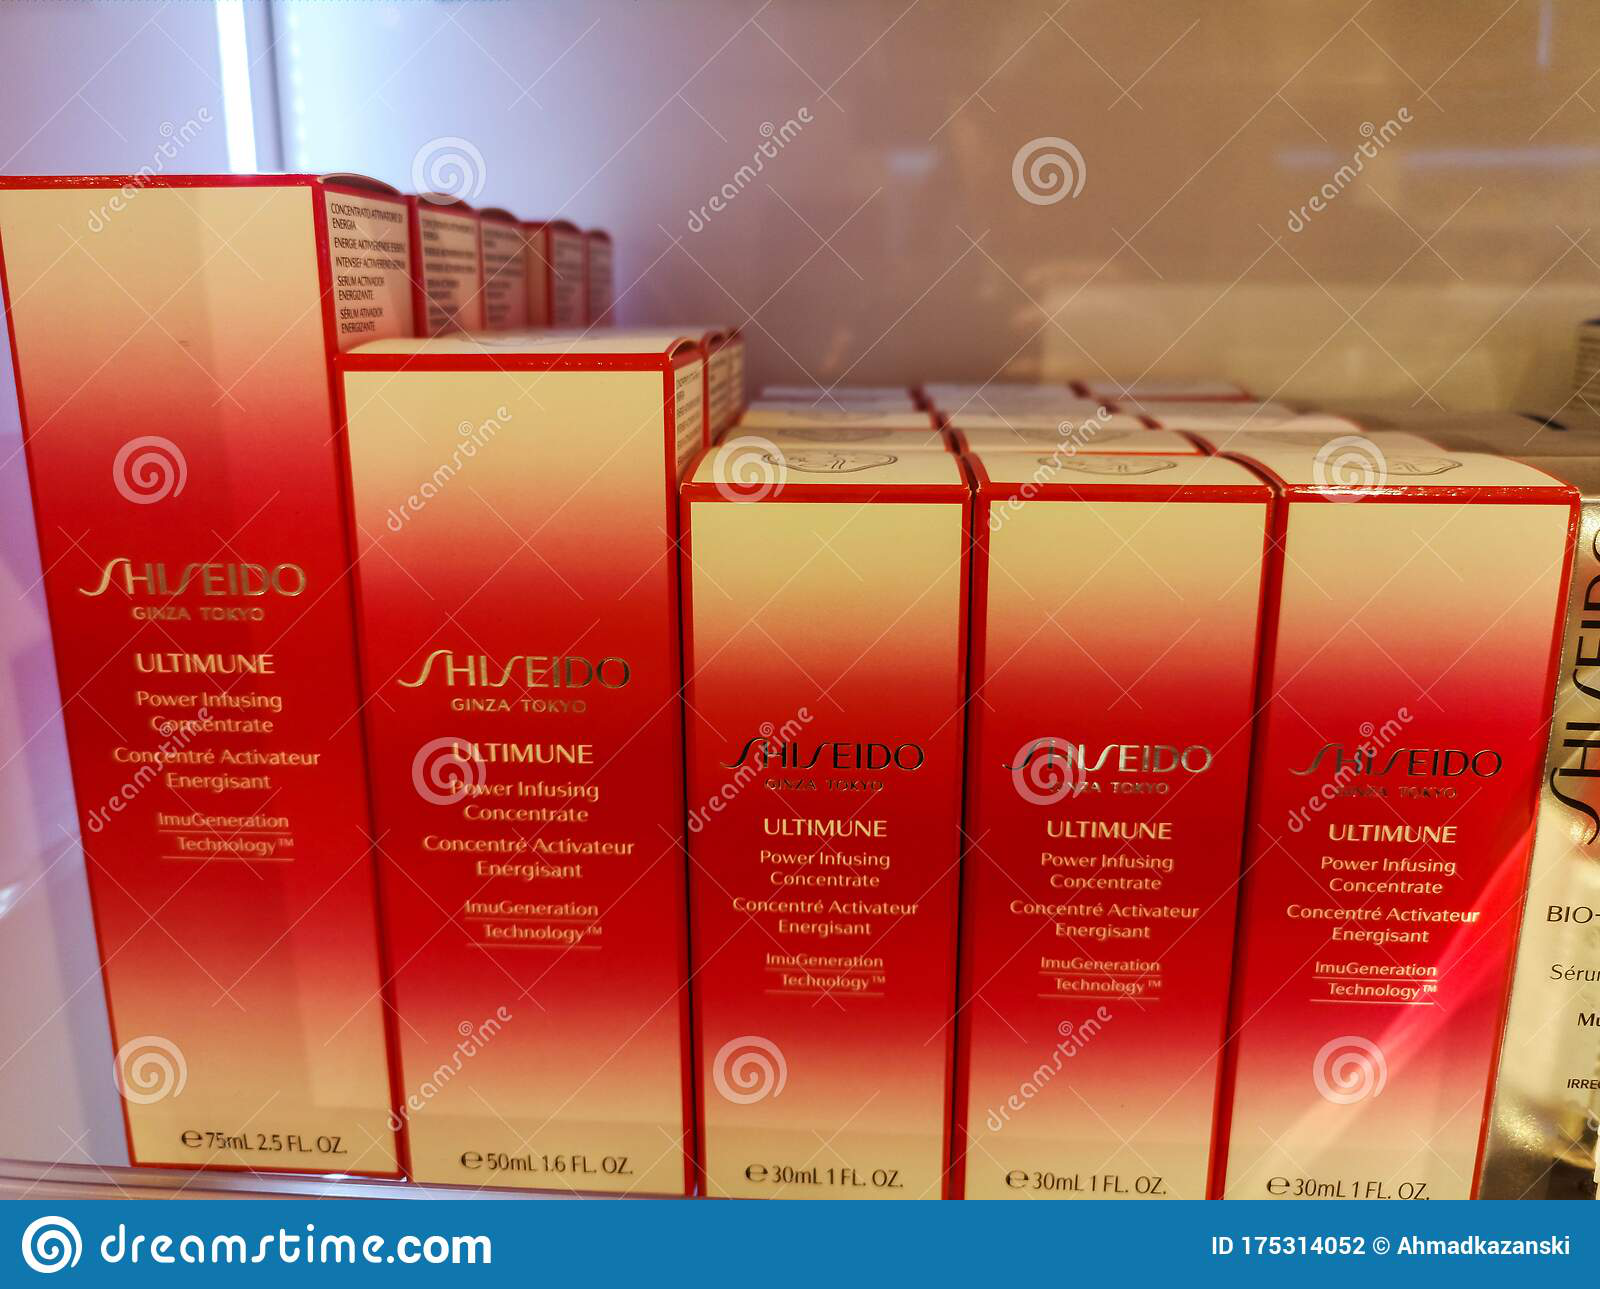

In [11]:
query_image = 'test/3.jpg'
img = Image.open(query_image)
img

Трансформируем изображение, получаем его дескриптор и ищем 9 похожих

In [12]:
distance, indices = search_img(img)

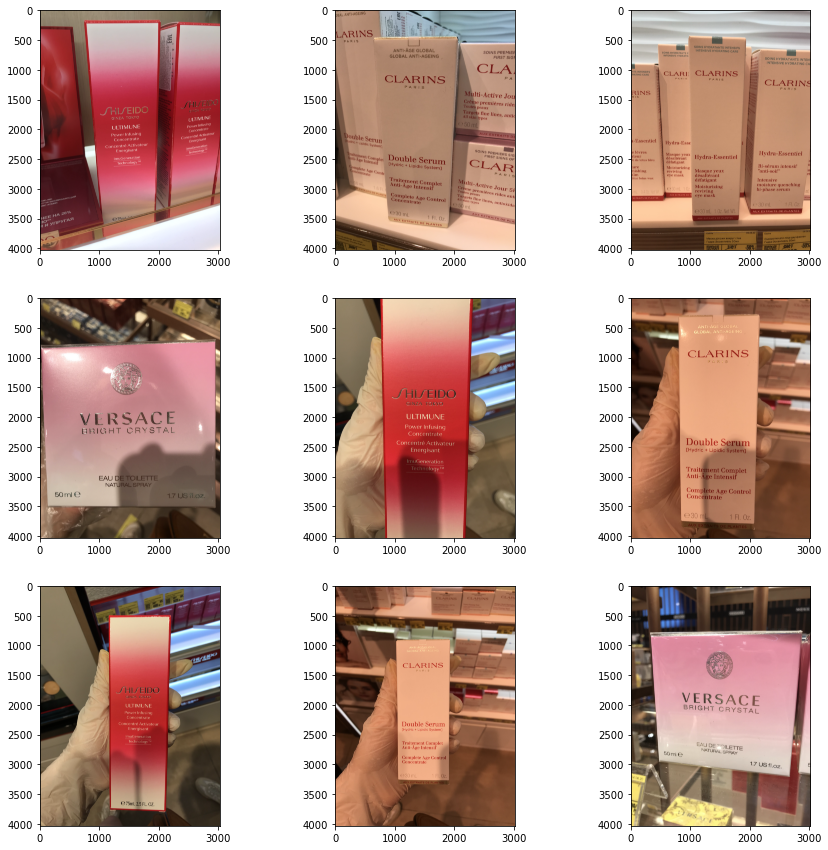

In [15]:
fig, ax = plt.subplots(3, 3, figsize=(15,15))
for file_index, ax_i in zip(indices[0], np.array(ax).flatten()):
    if image_paths[file_index][0].endswith('.heic'):
        img_show = read_heic_img(image_paths[file_index][0])
    else:
        img_show = Image.open(image_paths[file_index][0])
    ax_i.imshow(img_show)

plt.show()

# 3. Поиск слов на изображении с помощью OCR

Обрабатываем изображение несколькими способами и каждый раз ищем на нем слова, чтобы найти как можно больше слов

In [16]:
punctuation = string.punctuation + '“—'

#skew correction
def deskew(image):
    coords = np.column_stack(np.where(image > 0))
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return rotated

def set_image_dpi(im):
    length_x, width_y = im.size
    factor = min(1, float(1024.0 / length_x))
    size = int(factor * length_x), int(factor * width_y)
    im_resized = im.resize(size, Image.ANTIALIAS)
    temp_file = tempfile.NamedTemporaryFile(delete=False,   suffix='.jpg')
    temp_filename = temp_file.name
    im_resized.save(temp_filename, dpi=(300, 300))
    return temp_filename


def get_keywords(image):
    """
    Обработка изображения и поиск слов с помощью pytesseract
    :param image: изображение для поиска слов
    :return: множество set найденных слов
    """
    custom_config = r'--oem 3 --psm 3 -l fra+eng+rus+ita'
    image_bgr = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

    keywords = pytesseract.image_to_string(image_bgr, config=custom_config).split()

    clear_img = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY)
    clear_img = cv2.medianBlur(clear_img, 3)
    clear_img = cv2.Canny(clear_img, 100, 200)

    keywords = keywords + pytesseract.image_to_string(clear_img, config=custom_config).split()

    clear_img = deskew(clear_img)

    keywords = keywords + pytesseract.image_to_string(clear_img, config=custom_config).split()

    clear_img = Image.open(set_image_dpi(image))
    clear_img = cv2.cvtColor(np.array(clear_img), cv2.COLOR_RGB2GRAY)
    kernel = np.ones((1, 1), np.uint8)
    clear_img = cv2.dilate(clear_img, kernel, iterations=1)
    clear_img = cv2.erode(clear_img, kernel, iterations=1)
    cv2.adaptiveThreshold(cv2.bilateralFilter(clear_img, 9, 75, 75), 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                          cv2.THRESH_BINARY, 31, 2)

    keywords = keywords + pytesseract.image_to_string(clear_img, config=custom_config).split()
    keywords = [k.translate(str.maketrans('', '', punctuation)) for k in keywords]
    keywords = set([k.lower() for k in keywords if len(k) > 2])
    return keywords

Создание датасета products, файл output/product_keywords.pkl. Products содержит в себе path - путь к изображению продукта, name - название продукта, keywords - найденные слова

In [17]:
def generate_products_keywords():
    """
    Поиск с помощью OCR слов на каждом изображении в базе
    Создание датасета products, файл output/product_keywords.pkl
    Products содержит в себе path - путь к изображению продукта, name - название продукта, keywords - найденные слова
    """
    print('Generating products keywords...')
    product_files = glob.glob(config.PATH_TO_FILES + '/*/*')
    product_names = []
    product_paths = []
    product_keywords = []

    for product_file in product_files:
        name = product_file.split('/')[1]
        path = product_file.split('/', 1)[1]

        if path.endswith('.heic'):
            image = utils.read_heic_img(config.PATH_TO_FILES + '/' + path)
        else:
            image = Image.open(config.PATH_TO_FILES + '/' + path)

        keywords = keywords_utils.get_keywords(image)
        name_keywords = set(name.lower().split())

        product_names.append(name)
        product_paths.append(path)
        product_keywords.append(name_keywords | keywords)

    products = pd.DataFrame(data={'path': product_paths,
                                  'name': product_names,
                                  'keywords': product_keywords})

    products.to_pickle(PATH_TO_PRODUCT_DATASET)
    
# generate_products_keywords()
products = pd.read_pickle(PATH_TO_PRODUCT_DATASET)

# 4. Поиск названия продукта

Для поиска продукта взвешиваем результаты поиска CBIR модели и результаты OCR 

In [21]:
def perform_search(image):
    """
    Поиск названия продукта
    :param image: изображение для поиска
    :return: название продукта
    """
    try:
        image = Image.open(image)
    except FileNotFoundError:
        return 'По указанному пути изображения не существует'

    # ---Поиск с помощью OCR---
    # Получаем слова на изображении и находим количество пересечений со словами каждого продукта из базы
    ocr_keywords = get_keywords(image)
    products['intersection'] = [len(ocr_keywords & p) for p in products['keywords']]
    # Находим процент пересечений для каждого продукта
    # Чем больше процент - тем больше таких же слов у продукта, как и у входного изображения
    # Повышаем общий процент пересечений, умножая на 1.5
    total_sum = products.groupby(by='name')['intersection'].sum().sum()
    ocr_weighted_products = (products.groupby(by='name')['intersection'].sum().sort_values(ascending=False)
                             / total_sum) * 1.5
    ocr_weighted_products.fillna(0, inplace=True)

    # ---Поиск с помощью CBIR---
    # Находим расстояния до 9 самых похожих изображений из базы и их индексы
    distance, indices = search_img(image)
    distance_sum = sum(distance[0])
    cbir_weighted_names = defaultdict(int)
    # Считаем процент от общей суммы расстояний
    # Вычитаем из единицы, чтобы больший процент соответствовал более похожему изображению
    for idx in range(0, 9):
        name = image_paths[indices[0][idx]][0].split('/')[1]
        weight = 1 - (distance[0][idx] / distance_sum)
        cbir_weighted_names[name] = cbir_weighted_names[name] + weight

    # ---Взвешивание результатов---
    overall_weighted = {}
    # Вес продукта - среднее между процентом пересечений OCR и процентом расстояния CBIR
    # Берем во внимание проценты пересечений больше 0.15 (нижний порог), чтобы отсечь случайные пересечения
    # Сначала считаем среднее для 9 самых похожих изображений, найденных с помощью CBIR
    for key, value in cbir_weighted_names.items():
        if ocr_weighted_products[key] > 0.15:
            ocr_weight = ocr_weighted_products[key]
        else:
            ocr_weight = 0.0
        overall_weighted[key] = (cbir_weighted_names[key] + ocr_weight) / 2

    # Считаем среднее для продуктов, которые не были найдены с помощью CBIR,
    # но у которых большой процент пересечения слов OCR
    for key, value in ocr_weighted_products[ocr_weighted_products > 0.15].items():
        if key not in overall_weighted:
            overall_weighted[key] = (1.0 + value) / 2

    # Возвращаем название продукта, у которого получился самый большой вес
    return sorted(overall_weighted.items(), key=lambda item: item[1], reverse=True)[0][0]

# 5. Примеры

SHISEIDO ultimune


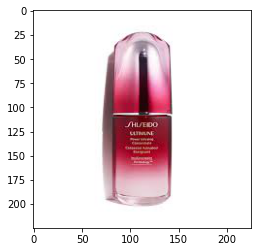

In [22]:
query_image = 'test/1.jpg'
print(perform_search(query_image))
plt.imshow(Image.open(query_image));

WELEDA deo roll-on


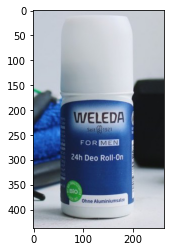

In [23]:
query_image = 'test/17.jpeg'
print(perform_search(query_image))
plt.imshow(Image.open(query_image));

CAUDALIE eau de beaute


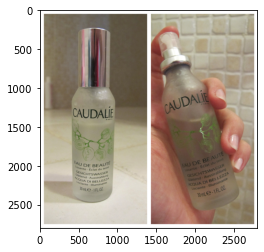

In [24]:
query_image = 'test/9.jpg'
print(perform_search(query_image))
plt.imshow(Image.open(query_image));

MAYBELLINE NEW YORK superstay matte ink


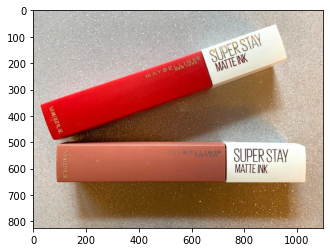

In [25]:
query_image = 'test/10.jpg'
print(perform_search(query_image))
plt.imshow(Image.open(query_image));

SLEEK i-divine eyeshadow palette


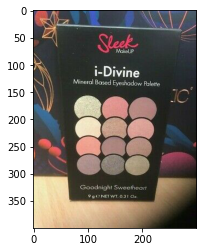

In [26]:
query_image = 'test/12.jpg'
print(perform_search(query_image))
plt.imshow(Image.open(query_image));

NAILLOOK trends suede


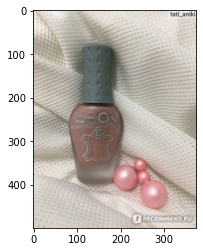

In [27]:
query_image = 'test/16.jpg'
print(perform_search(query_image))
plt.imshow(Image.open(query_image));

HELENA RUBINSTEIN powercell skinmunity


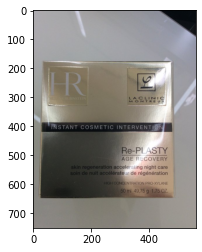

In [28]:
query_image = 'test/19.jpg'
print(perform_search(query_image))
plt.imshow(Image.open(query_image));

GUERLAIN orchidée impériale


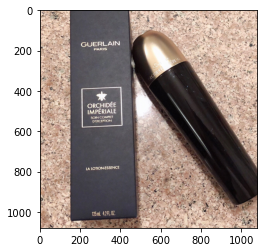

In [29]:
query_image = 'test/20.jpg'
print(perform_search(query_image))
plt.imshow(Image.open(query_image));

DOLCE & GABBANA 3 l'imperatrice


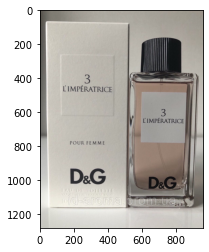

In [30]:
query_image = 'test/21.jpg'
print(perform_search(query_image))
plt.imshow(Image.open(query_image));

JOHN VARVATOS nick jonas silver


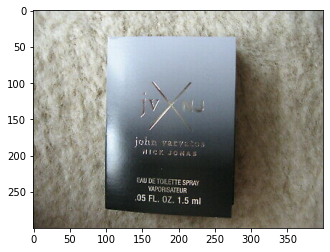

In [31]:
query_image = 'test/22.jpg'
print(perform_search(query_image))
plt.imshow(Image.open(query_image));

CLINIQUE clinique id bb-gel


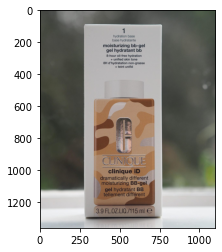

In [32]:
query_image = 'test/24.jpg'
print(perform_search(query_image))
plt.imshow(Image.open(query_image));

ACQUA DI PARMA bergamotto di calabria diffusor


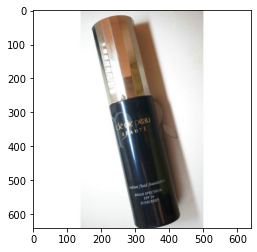

In [33]:
query_image = 'test/25.jpg' # неуд
print(perform_search(query_image))
plt.imshow(Image.open(query_image));

CLARINS double serum


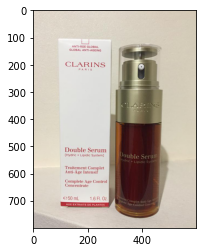

In [34]:
query_image = 'test/27.jpg'
print(perform_search(query_image))
plt.imshow(Image.open(query_image));

BOURJOIS brow fiber oh, oui!


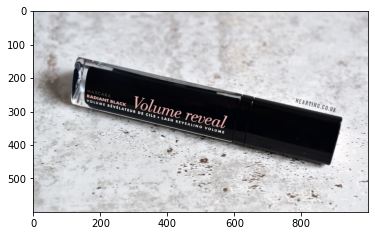

In [35]:
query_image = 'test/28.jpg'
print(perform_search(query_image))
plt.imshow(Image.open(query_image));

SHISEIDO ultimune


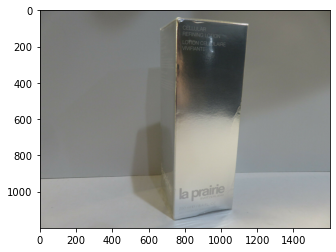

In [36]:
query_image = 'test/29.jpg' # неуд 
print(perform_search(query_image))
plt.imshow(Image.open(query_image));

GIORGIO ARMANI eye tint renovation


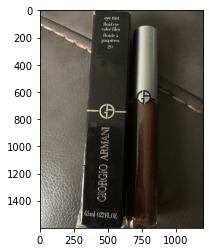

In [37]:
query_image = 'test/30.jpg' 
print(perform_search(query_image))
plt.imshow(Image.open(query_image));

ORGANIC SHOP тропический mango


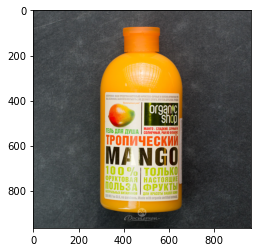

In [38]:
query_image = 'test/31.jpg' 
print(perform_search(query_image))
plt.imshow(Image.open(query_image));

CASAMORATI la tosca


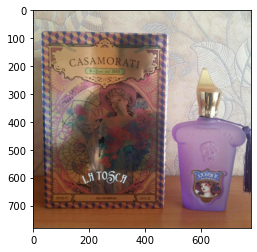

In [39]:
query_image = 'test/32.jpg' 
print(perform_search(query_image))
plt.imshow(Image.open(query_image));

ZIELINSKI & ROZEN orange & jasmine, vanilla


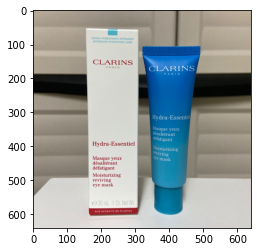

In [40]:
query_image = 'test/33.jpg'  # неуд
print(perform_search(query_image))
plt.imshow(Image.open(query_image));

LAMEL 16 shades of brown


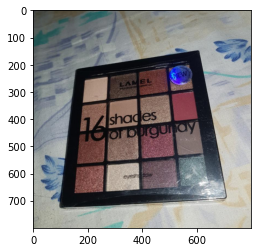

In [41]:
query_image = 'test/34.jpg'  
print(perform_search(query_image))
plt.imshow(Image.open(query_image));

ANNY nail polish


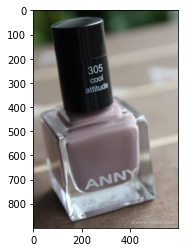

In [42]:
query_image = 'test/35.jpg'  
print(perform_search(query_image))
plt.imshow(Image.open(query_image));

# 6. Распознование с помощью скрипта

SHISEIDO ultimune


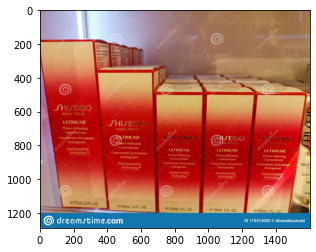

In [47]:
!python3 search.py --image 'test/3.jpg'
query_image = 'test/3.jpg'  
plt.imshow(Image.open(query_image));

3INA the cream eyeshadow


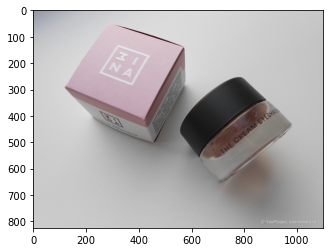

In [48]:
!python3 search.py --image 'test/11.jpg'
query_image = 'test/11.jpg'  
plt.imshow(Image.open(query_image));